<a href="https://colab.research.google.com/github/eitanfass/hydrology-data-science/blob/main/Thornthwaite%20and%20Panman%20ET%20comparison%20in%20two%20diffrent%20climates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# introduction
In this assigment I will compare two methods for calculating the ET potential transpiration. 
1. penmans method
2. Thornthwaite


For the comparison of the two methods i will calculate both for two diffrent locations in the US with two diffrent climates over one year.

For this purpose we will use data taken from the meteorological stations located in **Fairhope** (Alabama) and **St. paul** (Alaska) in 2017.
The climate in Fairhope is considered to be warm and humid wich is similer to the climate in the midwest (where Thornthwaite came up with his method). St Paul on the other hand has a very cold winter and a slightly warm summer.

I hypothosize that Fairhope will give us a better corolation between the two metods then ST. Paul will since Fairhope's climate is closer to the climate where Thornthwaite came up with his method.


It will be interesting to compare the different equations because the Penman's equation takes into account biological and phisical factors while Thornthwaite is an empirical equation.





In [ ]:
import matplotlib.pyplot as plt #importing relevent librarries
import numpy as np
import pandas as pd
from calendar import month_abbr
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
import urllib.request
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

first I will download the data from the metorological staitions:

In [ ]:
def download_data(station_name,year, staition_code ):#function that downloads data for a spcefic metorological staition and saves it in a csv file
    url_sub_hourly = 'https://www.ncei.noaa.gov/pub/data/uscrn/products/subhourly01/'
    url_header = 'https://www.ncei.noaa.gov/pub/data/uscrn/products/subhourly01/headers.txt'
    urllib.request.urlretrieve(url_sub_hourly +str(year)+'/'+ staition_code , station_name + '_sub_hourly.csv')
    df = pd.read_csv(station_name + '_sub_hourly.csv',
                 header=None,                      # no headers needed, we'll do that later
                 delim_whitespace=True,            # blank spaces separate between columns
                 na_values=["-99.000", "-9999.0"] ,
                 # substitute these values for missing (NaN) values
                )
    headers = pd.read_csv(url_header,    # load headers file
                      header=1,                    # skip the first [0] line
                      delim_whitespace=True
                     )
    l=headers.columns
    df.columns = headers.columns                     # rename df columns with headers columns
    # LST = local standard time
    df["LST_TIME"] = [f"{x:04d}" for x in df["LST_TIME"]]  # time needs padding of zeros, then convert to string
    df['LST_DATE'] = df['LST_DATE'].astype(str)            # convert date into string
    df['datetime'] = df['LST_DATE'] + ' ' + df['LST_TIME'] # combine date+time into datetime
           # interpret datetime
    df.to_csv('/content/drive/MyDrive/hydrology/assiment_02/'+station_name + '_sub_hourly.csv') 
                           # make datetime the index

In [ ]:
download_data('Fairhope',2017,'CRNS0101-05-2017-AL_Fairhope_3_NE.txt')
df_FH=pd.read_csv('/content/drive/MyDrive/hydrology/assiment_02/Fairhope_sub_hourly.csv')
df_FH['datetime'] = pd.to_datetime(df_FH['datetime'])
df_FH = df_FH.set_index('datetime')
download_data('St._Paul',2017,'CRNS0101-05-2017-AK_St._Paul_4_NE.txt')
df_SP=pd.read_csv('/content/drive/MyDrive/hydrology/assiment_02/St._Paul_sub_hourly.csv')
df_SP['datetime'] = pd.to_datetime(df_SP['datetime'])
df_SP = df_SP.set_index('datetime')
SP_alt=16
FH_alt=10
readme_file = "https://www.ncei.noaa.gov/pub/data/uscrn/products/subhourly01/readme.txt"
urllib.request.urlretrieve(readme_file , '/content/drive/MyDrive/hydrology/assiment_02/readme_file_sub_hourly.csv');



#Thornthwaite equation

Thorthwaite equation needs only the temperature and it can calculate the ET, this is its graetest advantege but also its greatest disadvantege since it is known that there are other factors that affect ET (for example wind, VPD, air resistance, etc).
It is important to note that this equation is empirical and therefore does not explain the physics behind things. In addition it is not suitable for every area

$$
\begin{equation}
E = 16\left[ \frac{10\,T^\text{monthly mean}}{I} \right]^a,
\end{equation}
$$
where
$$
\begin{equation}
I = \sum_{i=1}^{12} \left[ \frac{T_i^\text{monthly mean}}{5} \right]^{1.514},
\end{equation}
$$
and
$$
\begin{align}
a &= 6.75\times 10^{-7}I^3- 7.71\times 10^{-5}I^2 \nonumber\\
   &+ 1.792\times 10^{-2}I + 0.49239 \nonumber
\end{align}
$$

 - $E$ is the monthly potential ET (mm)
 - $T_\text{monthly mean}$ is the mean monthly temperature in °C
 - $I$ is a heat index
 - $a$ is a location-dependent coefficient


to caculate this we will need the monthly average temprature,
to do so we will resample our temprature data into monthly averages:

In [ ]:
def month_avg(df, column):# function that creats a monthly average of any column
  df=(df[column].resample('MS')  # MS assigns mean to first day in the month
                .mean()
                .to_frame()
        )
  return df


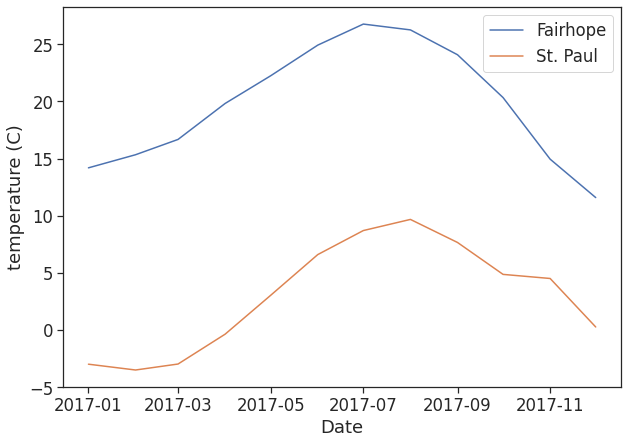

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,7))
df_FH_month=month_avg(df_FH,'AIR_TEMPERATURE')
df_SP_month=month_avg(df_SP,'AIR_TEMPERATURE')
df_FH_month=df_FH_month[1:]
df_SP_month=df_SP_month[1:]
plt.plot(df_FH_month,label='Fairhope')
ax.plot(df_SP_month,label='St. Paul')
ax.set(xlabel='Date',
       ylabel='temperature (C)')
ax.legend();

The above plot show's us the climate diffrences between the two location and we can see how St Paul is about 20 degrees colder then Fairhope all year long.</br>
Thornthwaite equation does not work with negetive temprature so inthe following code we will take all of the negetive temprature and turn it into 0

In [ ]:
def remove_neg(x):#function that removes negetive values and replaces them with 0
  if x<0:
    x=0
  return x

df_SP_month['AIR_TEMPERATURE']=df_SP_month['AIR_TEMPERATURE'].apply(remove_neg)

In [ ]:

def th_Ep(df):
  # Preparing "I" for the Thornthwaite equation
  I = np.sum( (df['AIR_TEMPERATURE']/5)**(1.514) )

  # Preparing "a" for the Thornthwaite equation
  a = (+6.75e-7 * I**3 
      -7.71e-5 * I**2
      +1.792e-2 * I
      + 0.49239)

  # The final Thornthwaite model for monthly potential ET (mm)
  df['Ep'] = 16*((10*df['AIR_TEMPERATURE']/I)**a)
  return df

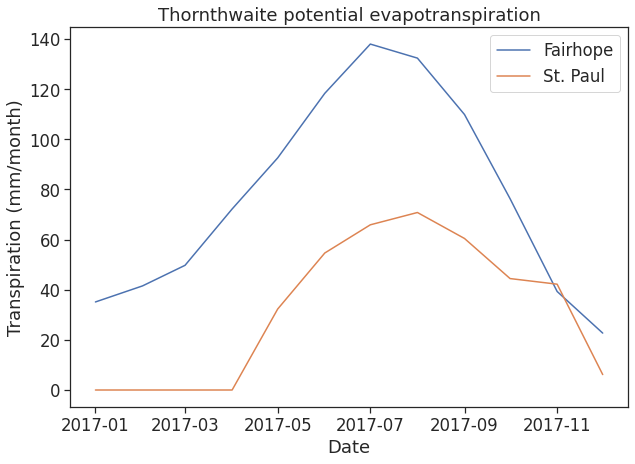

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,7))
df_FH_month=th_Ep(df_FH_month)
df_SP_month=th_Ep(df_SP_month)
ax.plot(df_FH_month['Ep'],label='Fairhope')
ax.plot(df_SP_month['Ep'],label='St. Paul')
ax.set(xlabel='Date',
       ylabel='Transpiration (mm/month)',
       title="Thornthwaite potential evapotranspiration")
ax.legend();

We will summarize the findings in the table


| Station | Fairhope | St. Paul |
| --- | --- | --- |
| Total annual ET |928 (mm)| 377 (mm) |
| Average ET | 77 (mm)|  31 (mm) |
| ET minimum (monthly average) | 23 (mm) | 0 (mm) |
| ET maximum (monthly average)  | 138 (mm) | 71 (mm) |

As you can see the ET in Fairehope is higher almost any time of the year. 
#Penman equation



Penman's equation takes into account many variables that affect ET. But it requires more data to be caculated.
We will now present the equation and all the parts that make it up:


$$
\begin{equation}
ET= \frac{1}{\lambda}\left[ \frac{\Delta}{\Delta+\gamma}Q_{ne}+ \frac{\gamma}{\Delta+\gamma}E_A \right],
\end{equation}
$$


where $Q_n$ is the available energy flux density

$$
\begin{equation}
Q_n = R_n - G
\end{equation}
$$

and $E_A$ is the drying power of the air

$$
\begin{equation}
E_A = 6.43\cdot f(u)\cdot\text{VPD}.
\end{equation}
$$


$$
  \begin{equation}
    \gamma = \frac{c_p\, P}{\lambda\cdot MW_\text{ratio}}
  \end{equation}
$$
  
  $$
  \begin{equation}
    P = 101.3-0.01055 H
  \end{equation}
  $$

  $$
  \begin{equation}
    \lambda = 2.501 - 2.361\times 10^{-3}\,T
  \end{equation}
  $$

* $MW_\text{ratio}=0.622$: ratio molecular weight of water vapor/dry air
* $P$: atmospheric pressure (kPa). Can be either measured or inferred from station height above sea level (m).
* $\lambda$: latent heat of water vaporization (MJ kg$^{-1}$)






 








$$
  \begin{equation}
    G = 4.2\frac{T_{i+1}-T_{i-1}}{\Delta t},
  \end{equation}
$$









$$\text{VPD} = e_s - e_d.$$

For temperatures ranging from 0 to 50 °C, the saturation vapor pressure can be calculated with:

$$
  \begin{equation}
    e_s = \exp \left[ \frac{16.78\, T -116.9}{T+237.3} \right],
  \end{equation}
$$

and the actual vapor pressure is given by

$$
  \begin{equation}
    e_d = e_s \frac{RH}{100},
  \end{equation}
$$











$$
  \begin{equation}
    \Delta = \frac{\text{d} e_s}{\text{d}T} = e_s(T)\cdot \frac{4098.79}{(T+237.3)^2}.
  \end{equation}
$$









$$
  \begin{equation}
    f(u) = 0.26(1.0 + 0.54\, u_2)
  \end{equation}
$$








The various components of the equations above are:

  $$
  \begin{equation}
    \Delta = 0.200 \cdot (0.00738\,T + 0.8072)^7 - 0.000116
  \end{equation}
  $$

  $$
  \begin{equation}
    \gamma = \frac{c_p\, P}{0.622 \lambda}
  \end{equation}
  $$
  
  $$
  \begin{equation}
    P = 101.3-0.01055 H
  \end{equation}
  $$

  $$
  \begin{equation}
    \lambda = 2.501 - 2.361\times 10^{-3}\,T
  \end{equation}
  $$

  $$
  \begin{equation}
    f_e(u) = 1.0 + 0.53\, u_2
  \end{equation}
  $$
  
  $$
  \begin{equation}
    G = 4.2\frac{T_{i+1}-T_{i-1}}{\Delta t}
  \end{equation}
  $$
  
  $$
  \begin{equation}
    e_s = \exp \left[ \frac{16.78\, T -116.9}{T+237.3} \right]
  \end{equation}
  $$
  
  $$
  \begin{equation}
    e_d = e_s \frac{RH}{100}
  \end{equation}
  $$
where $\Delta t$ is the time *in days* between midpoints of time periods $i+1$ and $i−1$, and $T$ is the air temperature (°C).


 - $\Delta$: slope of the saturation water vapor pressure curve (kPa °C$^{-1}$)
 - $\gamma$: psychrometric constant (kPA °C$^{-1}$)
 - $c_p=0.001013$: specific heat of water at constant pressure (MJ kg$^{-1}$ °C$^{-1}$)
 - $P$: atmospheric pressure (kPa)
 - $H$: elevation above sea level (m)
 - $\lambda$: latent heat of vaporization (MJ kg$^{-1}$)
 - $R_n$: net radiation (MJ m$^{-2} d^{-1}$)
 - $G$: heat flux density to the ground (MJ m$^{-2} d^{-1}$)
 - $u_{2}$: wind speed measured 2 m above ground (m s$^{-1}$)
 - $e_{s} - e_{d}$: vapor pressure deficit (kPa) 
 - $e_{s}$: saturation vapor pressure (kPa) 
 - $e_{d}$: actual vapor pressure (kPa) 

In [ ]:
def alt_to_p(z):#convert altitude to air pressure in mb
  P0=1.013*(10**2)
  H=7400
  return P0*np.exp(-(z/H))

Now i will create a data frame for the penman calculations called df_pen.
for this we will resample our sub hourely data into daily data.

In [ ]:
#==================================================
#                St. Paul resampling
#===================================================

df_pen_SP = (df_SP['AIR_TEMPERATURE'].resample('D')
                 .mean()
                 .to_frame()
         )
df_pen_SP["T"]=df_pen_SP["AIR_TEMPERATURE"]# copy "AIR_TEMPERATURE" column to 'T' column
df_pen_SP.drop('AIR_TEMPERATURE', inplace=True, axis=1)#deleting the "AIR_TEMPERATURE" column
df_pen_SP['RH'] = (df_SP['RELATIVE_HUMIDITY'].resample('D')
                                        .mean()
                      )
df_pen_SP['u'] = (df_SP['WIND_1_5'].resample('D')
                               .mean()
              )

df_pen_SP['p']=alt_to_p(SP_alt)#


In [ ]:
#==================================================
#                Fairhope resampling
#===================================================


df_pen_FH = (df_FH['AIR_TEMPERATURE'].resample('D')
                 .mean()
                 .to_frame()
         )
df_pen_FH["T"]=df_pen_FH["AIR_TEMPERATURE"]# copy "AIR_TEMPERATURE" column to 'T' column
df_pen_FH.drop('AIR_TEMPERATURE', inplace=True, axis=1)#deleting the "AIR_TEMPERATURE" column
df_pen_FH['RH'] = (df_FH['RELATIVE_HUMIDITY'].resample('D')
                                        .mean()
                      )
df_pen_FH['u'] = (df_FH['WIND_1_5'].resample('D')
                               .mean()
              )

df_pen_FH['p']=alt_to_p(FH_alt)

With average $T$ for every day, now i will calculate daily latent heat of vaporization $\lambda$, the slope of the saturation-vapor pressure-temperature curve $\Delta$, and the heat flux density to the ground $G$.  

I will also calculate f(u) using the wind data
and i will add all these caculations to the penman dataframe

In [ ]:
def lambda_latent_heat(T):
    """daily latent heat of vaporization (MJ/kg)"""
    return 2.501 - 2.361e-3*T

def Delta(T):
    """slope of saturation-vapor curve (kPa/°C)"""
    return 0.2000*(0.00738*T + 0.8072)**7 - 0.000116

def G(T):
    """heat flux density to the ground, G (MJ/m2/d)"""
    return 4.2*np.gradient(T.values)

#==================================================
#                St. Paul calculations
#===================================================

cp = 0.001013  # (MJ kg−1 °C−1) 
df_pen_SP['lambda'] = lambda_latent_heat(df_pen_SP['T'])
df_pen_SP['Delta'] = Delta(df_pen_SP['T'])
df_pen_SP['G'] = G(df_pen_SP['T'])
df_pen_SP['gamma'] = (cp*df_pen_SP['p'])/(0.622*df_pen_SP['lambda'])
df_pen_SP['f_wind'] = 1.0 + 0.53 * df_pen_SP['u']

#==================================================
#                Fairhope calculations
#===================================================


df_pen_FH['lambda'] = lambda_latent_heat(df_pen_FH['T'])
df_pen_FH['Delta'] = Delta(df_pen_FH['T'])
df_pen_FH['G'] = G(df_pen_FH['T'])
df_pen_FH['gamma'] = (cp*df_pen_FH['p'])/(0.622*df_pen_FH['lambda'])
df_pen_FH['f_wind'] = 1.0 + 0.53 * df_pen_FH['u']



The $R_{so}$ is the mean solar radiation from a cloudless sky based on latitude
The $R_s$ this data can be found in [meteorological charts](https://yairmau.github.io/website/markdown/2020/02/03/evapotranspiration-lecture.html#:~:text=%2C%20from-)

In [ ]:

# MJ/m2/d
Rso_monthly_FH = np.array([17.46, 21.65, 25.96, 29.85,
                        32.11, 33.20, 32.66, 30.44,
                        26.67, 22.48, 18.30, 16.04])

Rso_monthly_SP = np.array([2.51, 5.99, 13.82, 22.32,
                        29.01, 31.95, 29.85, 23.32,
                        15.78, 8.5, 3.64, 1.55])
    
# create empty columns
df_pen_FH["Rso_monthly"] = ""
df_pen_SP["Rso_monthly"] = ""

# every day in the month will have the same values for Rso
for i in range(12):
    df_pen_SP.loc[df_pen_SP.index.month==(i+1), "Rso_monthly"] = Rso_monthly_SP[i]
    df_pen_FH.loc[df_pen_FH.index.month==(i+1), "Rso_monthly"] = Rso_monthly_FH[i]


Now that we have added the $R_{so}$ values for monthly averages we need to fit a curve so that the increase and decrease of $R_{so}$ will be moderate and not in big steps. the folowing code fits a curve to  $R_{so}$ values.



In [ ]:

middle = pd.date_range(start='1/1/2017', periods=12, freq='MS') + pd.DateOffset(days=14)
new_FH = df_pen_FH.loc[middle, 'Rso_monthly'].astype('float')
new_SP= df_pen_SP.loc[middle, 'Rso_monthly'].astype('float')
df_i_FH = (pd.DataFrame(data=new_FH, index=new_FH.index) #create the dataframe
           .resample("D") #resample daily
           .interpolate(method='time') #interpolate by time
       )
df_i_SP = (pd.DataFrame(data=new_SP, index=new_SP.index) #create the dataframe
           .resample("D") #resample daily
           .interpolate(method='time') #interpolate by time
       )


Now for the solar radiation measured in the sub hourly data i will resample the data to daily average and the convert units and turn all negative values to 0. 

In [ ]:
#==================================================
#                St. Paul calculations
#===================================================

df_pen_SP['Rs'] = (df_SP['SOLAR_RADIATION'].resample('D')
                               .mean()
              )
df_pen_SP['Rs']=df_pen_SP['Rs'].apply(remove_neg)
df_pen_SP['Rs (MJ/m2D)']=df_pen_SP['Rs']*3600*24/(10**6)#unit conversion

#==================================================
#                Fairhope calculations
#===================================================

df_pen_FH['Rs'] = (df_FH['SOLAR_RADIATION'].resample('D')
                               .mean()
              )
df_pen_FH['Rs']=df_pen_FH['Rs'].apply(remove_neg)
df_pen_FH['Rs (MJ/m2D)']=df_pen_FH['Rs']*3600*24/(10**6)#unit conversion from (W/m^2) to (MJ/D*m^2)

Now I will calculate the $R_{n}$ for both stations, for this i will use the following equation:

$$R_n = (1-\alpha)R_s\!\! \downarrow -R_b \!\! \uparrow,$$

where $\alpha$ (dimensionless) is the albedo we will use a value of $\alpha$=0.23 witch is the albedo for green vegetation.
The net outgoing thermal radiation $R_b$ is given by

$$R_b = \left( a\frac{R_s}{R_{so}+b} \right)R_{bo},$$

where $R_{so}$ is alredy known to us from the code above.
$R_{bo}$ is caculated stefan boltzmann equation:

$$R_{bo} = \epsilon\, \sigma\, T^4_{Kelvin},$$

where the stefan boltzmann constant is $\sigma=4.903\times 10^{-9}$ MJ m$^{-2}$ d$^{-1}$ K$^{-4}$,</br> and $\epsilon$ is net net emissivity:

$$\epsilon=-0.02+0.261 \exp\left(-7.77\times10^{-4}T_{Celcius}\right).$$

The parameters $a$ and $b$ are determined for the climate of the area:
* $a=1.0$, $b=0.0$ for humid areas,
* $a=1.2$, $b=-0.2$ for arid areas,
* $a=1.1$, $b=-0.1$ for semihumid areas.</br></br>
In our case after analizing the stations data Fairehope and St. Paul will be considered a humid climet.

In [ ]:
def emissivity(df_pen):
  return -0.02 + 0.261 * np.exp(-7.77e-4 * df_pen['T']**2)



def Rbo(df_pen):# Rbo: net longwave radiation for clear skies
  sigma = 4.903e-9# Stefan-Boltzmann constant
  return emissivity(df_pen)*sigma*((df_pen['T']+273.15)**4)
# net outgoing long-wave radiation (note: Rs/Rso = proportion of how clear the day is)
def Rb(a,b,df_pen):
  return(a*df_pen['Rs (MJ/m2D)']/df_pen['Rso_monthly'] + b)*Rbo(df_pen)  


# α is the albedo, or short-wave reflectance (dimensionless)
alpha = 0.23# albedo for green vegetation
# net radiation
Rn_FH = (1 - alpha) * df_pen_FH['Rs (MJ/m2D)'] - Rb(1,0,df_pen_FH)# (MJ/m2/d)
Rn_SP = (1 - alpha) * df_pen_SP['Rs (MJ/m2D)'] - Rb(1,0,df_pen_SP)   
df_pen_FH['Rn'] = Rn_FH
df_pen_SP['Rn'] = Rn_SP

Now I will calculate the vapor pressure deficit, VPD using the following equations.

$$e_d = e_s\cdot \frac{RH}{100}$$

$$e_s = \exp\left(\frac{16.78\,T-116.9}{T+237.3}\right)$$

In [ ]:
# vapor pressure deficit = VPD
def vp_sat(T):
    return np.exp((16.78*T - 116.9)/(T + 237.3)) 
df_pen_FH['es'] = vp_sat(df_pen_FH['T'])
df_pen_FH['ed'] = df_pen_FH['es'] * df_pen_FH['RH'] / 100
df_pen_FH['VPD'] = df_pen_FH['es'] - df_pen_FH['ed']

df_pen_SP['es'] = vp_sat(df_pen_SP['T'])
df_pen_SP['ed'] = df_pen_SP['es'] * df_pen_SP['RH'] / 100
df_pen_SP['VPD'] = df_pen_SP['es'] - df_pen_SP['ed']


Now I have values for all variables needed to caculate the ET by penman's equation. 

$$
\begin{equation}
E_{tp} = \frac{\Delta}{\Delta+\gamma}Q_{ne}+ \frac{\gamma}{\Delta+\gamma}E_A
\end{equation}
$$

$Q_n$ is the available energy flux density:

$$
\begin{equation}
Q_n = R_n - G,
\end{equation}
$$

and $E_A$ is the drying power of the air:

$$
\begin{equation}
E_A = f_e(u)\cdot\text{VPD}
\end{equation}
$$

Lets add a new column `E_penman` to `df_pen`:

In [ ]:
def E_penman(df):
    T = df['T']
    Delta = df['Delta']
    gamma = df['gamma']
    Rn = df['Rn']
    G = df['G']
    EA = 6.43*df['f_wind'] * df['VPD']
    lambd = df['lambda']
    return ((Delta / (Delta + gamma))*(Rn - G) + ((gamma / (Delta + gamma))*EA)) / lambd

# daily_data
df_pen_FH['E_penman'] = E_penman(df_pen_FH)
df_pen_SP['E_penman'] = E_penman(df_pen_SP)
df_pen_SP['E_penman']=df_pen_SP['E_penman'].apply(remove_neg)#removing negetive values 
df_pen_FH['E_penman']=df_pen_FH['E_penman'].apply(remove_neg)


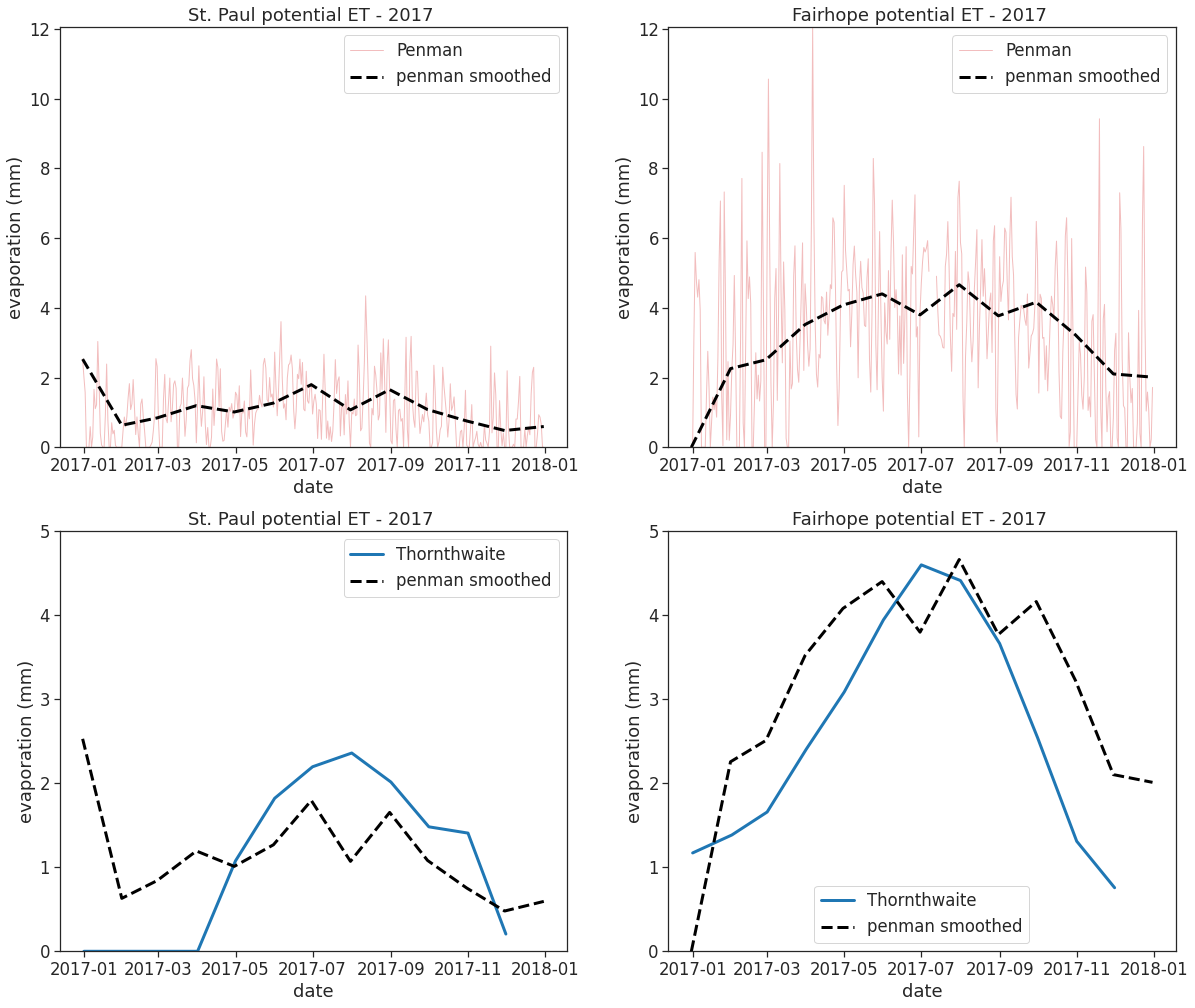

In [ ]:
#==================================================
#                St. Paul graph
#===================================================

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(20,17))
ax1.plot(df_pen_SP['E_penman'], color="tab:red",alpha=0.3, label="Penman", linewidth=1)
penman_smooth_SP= (df_pen_SP['E_penman'].resample('M')
                               .mean()
              )
ax1.plot(penman_smooth_SP, label='penman smoothed', color="black", linestyle="--", linewidth=3)
ax1.set(xlabel="date",
       ylabel="evaporation (mm)",
       title="St. Paul potential ET - 2017 ",
        ylim=(0,df_pen_FH['E_penman'].max()))
ax1.legend()

ax3.plot(df_SP_month['Ep']/30, color="tab:blue", label="Thornthwaite", linewidth=3) #we have to normalize the results of df_th
ax3.plot(penman_smooth_SP, label='penman smoothed', color="black", linestyle="--", linewidth=3)
ax3.set(xlabel="date",
       ylabel="evaporation (mm)",
       title="St. Paul potential ET - 2017 ",
        ylim=(0,5))
ax3.legend()


#==================================================
#                Fairhope graph
#===================================================


ax2.plot(df_pen_FH['E_penman'], color="tab:red",alpha=0.3, label="Penman", linewidth=1)

df=df_pen_FH['E_penman'].dropna()
penman_smooth_FH= (df_pen_FH['E_penman'].resample('M')
                               .mean()
              )       #smooth avarege
ax2.plot(penman_smooth_FH, label='penman smoothed', color="black", linestyle="--", linewidth=3)
ax2.set(xlabel="date",
       ylabel="evaporation (mm)",
       title="Fairhope potential ET - 2017 ",
        ylim=(0,df_pen_FH['E_penman'].max()))
ax2.legend();
ax4.plot(df_FH_month['Ep']/30, color="tab:blue", label="Thornthwaite", linewidth=3) #we have to normalize the results of df_th
ax4.plot(penman_smooth_FH, label='penman smoothed', color="black", linestyle="--", linewidth=3)
ax4.set(xlabel="date",
       ylabel="evaporation (mm)",
       title="Fairhope potential ET - 2017 ",
        ylim=(0,5))
ax4.legend();

on the top row of above plot is a represantation of Penman ET with daily data and with monthly mean. and on the bottom row we have the penman ET monthly mean with respect to the Thorthwaite ET.</br>in our  compairison of the two mrthods in diffrent climats we can see that as I hypothosized in Fairhope there is a good corolation between the two methods, since the weather conditions are similer to where Thorthwaite equation was created.</br>
On the othe hand we can see that in St. Paul witch has negetive tempreture in the winter and is in diffrent weather conditions from where Thonrthwaite was created we have a corolation but not in thewitnter months with negetive degrees since thorthwaite cant calculate the ET for negetive C degrees.
#Conclusions:
In general Penman's method is considered to be more accurate since it is a representation of the phisical forces at play during traspiration while Thorthwaite is an emperical method to find the transpiration using the air temprature.</br>
</br>
small diffrences aside The impression from the two graphs is relatively the same.
Thorthwaight and penman show us similer trends of ET. The main significance of this conclusion depends on our desire to accurately predict ET and the measurments available to us. In case we want to get a general assessment of the trend of ET or we dont have enaugh data it is definitely possible to use Thornthwaite estimation. When we want to observe a sharper resolution and identify subtle differences we will need to use the Penman equation.